# **GIS × Python Tutorial 4.3 ~ 時々使うその他のメソッド ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。


<br>

## **はじめに**
---
前回は **shapely** の Geometry が持つメソッドに関して解説しました。空間検索などのメソッドを紹介します。


<br>

In [67]:
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from shapely.plotting import plot_line
from shapely.plotting import plot_points
from shapely.plotting import plot_polygon
plt.style.use('seaborn-v0_8-whitegrid')
japanize_matplotlib.japanize()

<br>

## **凸包によるPolygonの作成**
---
shapely では 'shapely.convex_hull' のメソッドが用意されており、 `shapely.geometry.MultiPoint`を渡す事で簡単に凸包でPolygonを作成する事が出来ます。

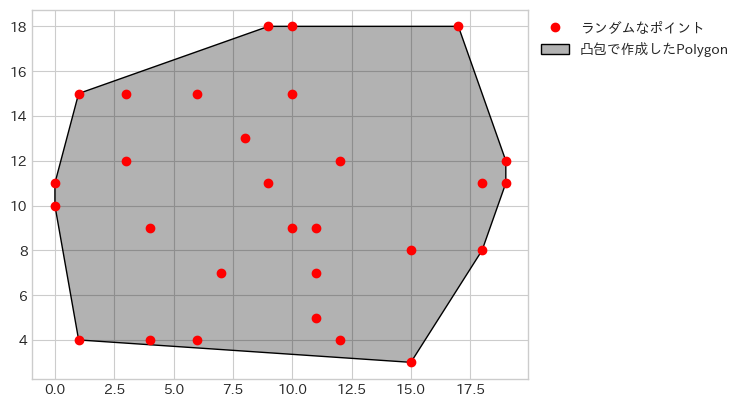

In [115]:
xs = np.random.randint(0, 20, 30)
ys = np.random.randint(0, 20, 30)
points = list(set([
    shapely.Point(x, y)
    for x, y in zip(xs, ys)
]))
# 凸包でPolygonを作成する
poly = shapely.convex_hull(shapely.MultiPoint(points))

fig, ax = plt.subplots()
plot_points(points, ax, 'red', label='ランダムなポイント')
plot_polygon(poly, ax, False, 'black', label='凸包で作成したPolygon')
ax.legend(bbox_to_anchor=(1, 1));

<br>

## **凹包によるPolygonの作成**
---
shapely では 'shapely.concave_hull' のメソッドが用意されており、 `shapely.geometry.MultiPoint`を渡す事で簡単に凹包でPolygonを作成する事が出来ます。

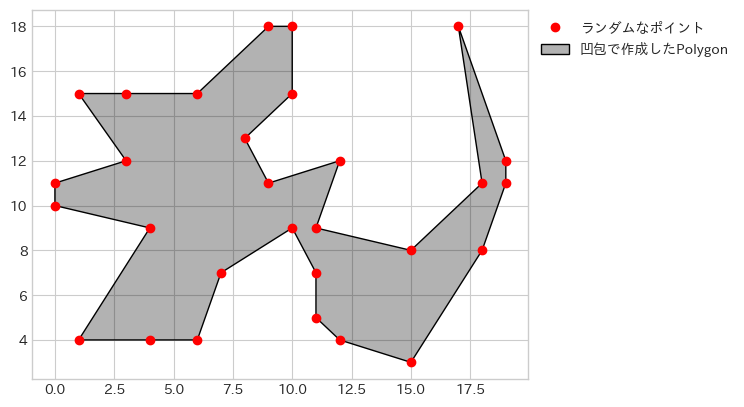

In [239]:
# 凹包でPolygonを作成する
poly = shapely.concave_hull(shapely.MultiPoint(points))

fig, ax = plt.subplots()
plot_points(points, ax, 'red', label='ランダムなポイント')
plot_polygon(poly, ax, False, 'black', label='凹包で作成したPolygon')
ax.legend(bbox_to_anchor=(1, 1));

## **ドロネー三角形分割**
---
ドロネー三角形分割は、距離空間内に離散的に分布した点の集合に対して得られる特定の三角形分割です。shapely では `shapely.delaunay_triangles` というメソッドが用意されています。

実行して Geometry型を確認するとわかりますが、MultiPolygon ではなく `GeometryCollection` が返ってきています。

In [117]:
triangles = shapely.delaunay_triangles(shapely.MultiPoint(points))

print(type(triangles))

<class 'shapely.geometry.collection.GeometryCollection'>


GeometryCollection は Point や LineString 、Polygon などを一緒に格納できる Geometry 型で、今回の様に `shapely.delaunay_triangles` を使用した場合や、`shapely.make_valid` で Geometry を修正した場合等に返ってきます。

ちょっと中身を見てみましょう。GeometryCollection から各 Geometry を取り出す場合は `shapely.get_parts` を使用するとイテレーションする事が出来ます。

In [118]:
for i, geom in enumerate(shapely.get_parts(triangles)):
    print(f"{i}: {type(geom)}")

0: <class 'shapely.geometry.polygon.Polygon'>
1: <class 'shapely.geometry.polygon.Polygon'>
2: <class 'shapely.geometry.polygon.Polygon'>
3: <class 'shapely.geometry.polygon.Polygon'>
4: <class 'shapely.geometry.polygon.Polygon'>
5: <class 'shapely.geometry.polygon.Polygon'>
6: <class 'shapely.geometry.polygon.Polygon'>
7: <class 'shapely.geometry.polygon.Polygon'>
8: <class 'shapely.geometry.polygon.Polygon'>
9: <class 'shapely.geometry.polygon.Polygon'>
10: <class 'shapely.geometry.polygon.Polygon'>
11: <class 'shapely.geometry.polygon.Polygon'>
12: <class 'shapely.geometry.polygon.Polygon'>
13: <class 'shapely.geometry.polygon.Polygon'>
14: <class 'shapely.geometry.polygon.Polygon'>
15: <class 'shapely.geometry.polygon.Polygon'>
16: <class 'shapely.geometry.polygon.Polygon'>
17: <class 'shapely.geometry.polygon.Polygon'>
18: <class 'shapely.geometry.polygon.Polygon'>
19: <class 'shapely.geometry.polygon.Polygon'>
20: <class 'shapely.geometry.polygon.Polygon'>
21: <class 'shapely.geo

Polygon しかありません。可視化してみましょう。

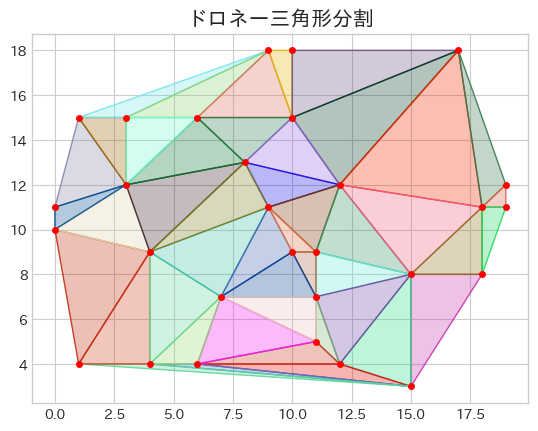

In [119]:
fig, ax = plt.subplots()
ax.set_title('ドロネー三角形分割', fontsize=15)
for triangle in shapely.get_parts(triangles):
    if shapely.get_type_id(triangle) == 3:
        c = np.random.random(3).tolist() + [0.9]
        plot_polygon(triangle, ax, False, c)
plot_points(points, ax=ax, color='red', markersize=4);

## **ボロノイ図の作成**
---
ボロノイ図は、ある距離空間上の任意の位置に配置された複数個の母点に対して、同一距離空間上の母点がどの母点に近いかによって領域わけされた図の事です。shapely では `shapely.voronoi_polygons` というメソッドが用意されています。

こちらも GeometryCollection で返ってくるので Polygon のみを取り出して可視化してみます。


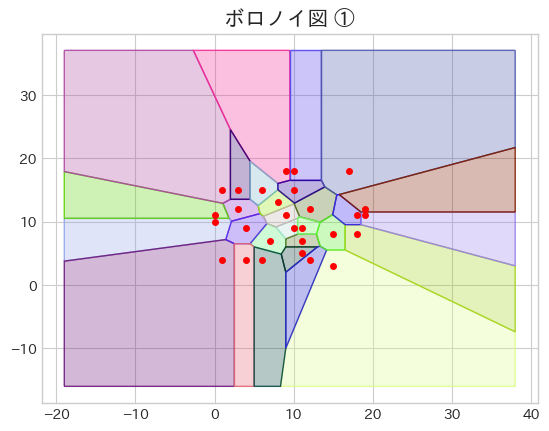

In [120]:
voronoi_collection = shapely.voronoi_polygons(shapely.MultiPoint(points))

fig, ax = plt.subplots()
ax.set_title('ボロノイ図 ①', fontsize=15)
for geom in shapely.get_parts(voronoi_collection):
    if shapely.get_type_id(geom) == 3:
        c = np.random.random(3).tolist() + [0.9]
        plot_polygon(geom, ax, False, c)
plot_points(points, ax=ax, color='red', markersize=4);

もしもこれが市町村などにある店舗を表現する Point であり、それらの領域を可視化したいという事ならば、geometry.`intersection`を使用して取り出す事が出来ます。

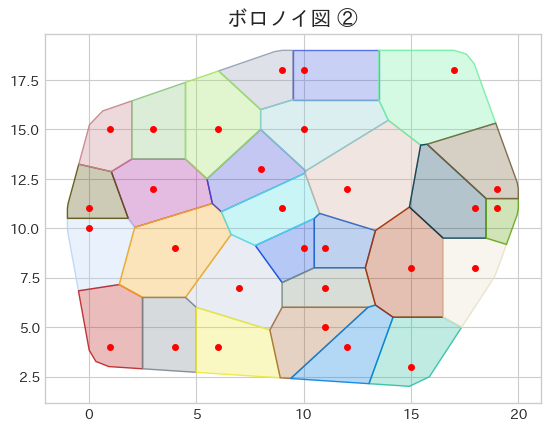

In [121]:
# 適当に境界線を作成する
boundary = shapely.MultiPoint(points).convex_hull.buffer(1, quad_segs=2)

fig, ax = plt.subplots()
ax.set_title('ボロノイ図 ②', fontsize=15)
# Polygonのみの取り出し、差分を計算して可視化
voronoi_polys = []
for geom in shapely.get_parts(voronoi_collection):
    if shapely.get_type_id(geom) == 3:
        poly = geom.intersection(boundary)
        c = np.random.random(3).tolist() + [0.9]
        plot_polygon(poly, ax, False, c)
        voronoi_polys.append(poly)
plot_points(points, ax=ax, color='red', markersize=4);


<br>

## **おわりに**
---
shapely の主な使用方法はこの記事で終わりにする予定です。`shapely.intersects`などの空間検索も協力なメソッドですが shaeply単体で使用するよりも geopandas と一緒に使用した方が良いので、geopandas の記事で紹介したいと思います。

<br>

## 参考
---
https://ja.wikipedia.org/wiki/%E5%87%B8%E5%8C%85

https://ja.wikipedia.org/wiki/%E3%83%89%E3%83%AD%E3%83%8D%E3%83%BC%E5%9B%B3

https://ja.wikipedia.org/wiki/%E3%83%9C%E3%83%AD%E3%83%8E%E3%82%A4%E5%9B%B3